<a id="top"></a>
# UN SDG Indicator 6.6.1:<br> Change in the Extent of Water-related Ecosystems


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

In the first section, one time period is analyzed. The mean of water classifications over time is visualized, the minimum and maximum water extents are visualized, and the frequency of water classification for each pixel is visualized.

In the second section, two time periods are analyzed - a baseline time period and an analysis time period. The change in pixels that are water at any time during their respective time periods is calculated, the change in water from the baseline time period to the analysis time period is visualized, and the area is classified by degree of change using classification labels provided by UN SDG 6.6.1.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Analyze a Single Time Period](#single_period)
    * [Define the Extents of the Analysis](#define_extents_single)
    * [Retrieve the Data from the Datacube](#retrieve_data_single)
    * [Get Water Classifications Using the WOFS Algorithm](#water_cls_single)
    * [Prepare for Visualization](#prepare_for_vis)
    * [Find the Minimum and Maximum Water Extents](#find_water_extents)
    * [Create Water Extent Image](#water_extent_image)
    * [Create a Time Series Plot of the Water](#time_series_water)
* [Compare Two Time Periods - a Baseline and an Analysis](#two_period)
    * [Define the Extents of the Analysis](#define_extents_baseline_analysis)
    * [Retrieve the Data from the Datacube](#retrieve_data_baseline_analysis)
    * [Get Water Classifications Using the WOFS Algorithm](#water_cls_baseline_analysis)
    * [Show and Analyze the Differences Between the Two Time Periods](#show_analyze_diff)
    * [Classify the Area by Degree of Change](#classify_by_degree_change)

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Allow importing of our utilities.
import sys
sys.path.append("..")

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <a id="plat_prod"></a>Choose Platforms and Products [&#9652;](#top)

**List available products for each platform**

In [4]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

In [6]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
platforms = ['LANDSAT_7', 'LANDSAT_8']
products = ['ls7_ledaps_ghana', 'ls8_lasrc_ghana']

## <a id="extents"></a>Get the Extents of the Cube [&#9652;](#top)

In [7]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
# Get the area common to all products.
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

In [8]:
from utils.data_cube_utilities.dc_time import dt_to_str
print("Available Latitude Extents:", full_lat)
print("Available Longitude Extents:", full_lon)
print("Available Time Extents:", np.vectorize(dt_to_str)(min_max_dates))

Available Latitude Extents: (3.772924193304, 11.318772579912)
Available Longitude Extents: (-3.772924193304, 1.886462096652)
Available Time Extents: [['2000-01-01' '2019-01-30']
 ['2013-04-13' '2019-02-16']]


**Visualize the full area**

In [9]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <a id="single_period"></a>Analyze a Single Time Period  [&#9652;](#top)

### <a id="define_extents_single"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates**

In [10]:
# Select a subset of the time available.
time_extents = [dt.datetime(2014,1,1), dt.datetime(2014,12,31)]

**Specify an area to analyze**

In [11]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

# Ghana
# lat = (6.5016, 6.5221) # Lake Volta (very small)
# lon = (-0.1618, -0.100) # Lake Volta (very small)
# lat = (6.5016, 6.5821) # Lake Volta (small)
# lon = (-0.1618, -0.055) # Lake Volta (small)
# lat = (6.5138, 6.5292) # Lake Volta (medium)
# lon = (-0.1669, -0.1493) # Lake Volta (medium)
# lat = (6.2989, 7.9287) # Lake Volta (large)
# lon = (-0.4559, 0.2637) # Lake Volta (large)
lat =  (10.8524, 10.9457) # Tono Dam
lon = (-1.2034, -1.1323) # Tono Dam

# Lake Sulunga, Tanzania
# lat = (-6.3605, -5.8252) # Large 
# lon = (34.9756, 35.4535) # Large
# lat = (-6.2593, -5.8701) # Small (close fit)
# lon = (34.9901, 35.3641) #  Small (close fit)

# Lake Manyara, Tanzania
# lat = (-3.8505, -3.3886) 
# lon = (35.7184, 35.9271)

# Vietnam
# lat = (10.037934, 10.237934) 
# lon = (104.992264, 105.192264)
# lat = (11.0645, 11.2845) # Tri An Lake
# lon = (106.9567, 107.2967) # Tri An Lake

**Visualize the selected area**

In [12]:
display_map(lat, lon)

### <a id="retrieve_data_single"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [13]:
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.sort import xarray_sortby_coord

def load_for_time_range(platform, product, time_extents):
    measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
    matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat)
    datasets = {}
    clean_masks = {}
    for platform, product in zip(platforms, products):
        # Load the dataset.
        dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                          time=time_extents, measurements=measurements)
        if len(dataset.dims) == 0: # The dataset is empty.
            continue
        datasets[product] = dataset
        # Get the clean mask.
        clean_mask = (landsat_qa_clean_mask(dataset, platform) &
                      (dataset[measurements[0]] != -9999) &
                      landsat_clean_mask_invalid(dataset))\
                     .astype(np.uint8)
        dataset = dataset.drop('pixel_qa')    
        # Discard acquisitions with no clean data.
        acq_times_to_keep = dataset.time.values[(clean_mask.mean(['latitude', 'longitude']) > 0.001).values]
        dataset = dataset.sel(time=acq_times_to_keep)
        clean_mask = clean_mask.sel(time=acq_times_to_keep)
        # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
        if not same_dim_sizes:    
            dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
            clean_mask = xr_scale_res(clean_mask, abs_res=matching_abs_res)
        clean_mask = clean_mask.astype(np.bool)
        # Clean the data.
        dataset = dataset.astype(np.float16).where(clean_mask)
        datasets[product], clean_masks[product] = dataset, clean_mask
    # Combine everything.
    if len(datasets) > 0:
        dataset = xarray_sortby_coord(xr.concat(list(datasets.values()), dim='time'), coord='time')
        clean_mask = xarray_sortby_coord(xr.concat(list(clean_masks.values()), dim='time'), coord='time')
    else:
        dataset = xr.Dataset()
        clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    return dataset, clean_mask

In [14]:
dataset, clean_mask = load_for_time_range(platforms[1], products[1], time_extents)


### <a id="water_cls_single"></a> Get Water Classifications Using the WOFS Algorithm [&#9652;](#top)

In [15]:
# Whether or not to denoise the WOFS classifications.
denoise = False

# Denoising parameters may need to be tuned depending on the region and resolution scaling.
# Min Size = Smallest dimensions of a block of pixels. 2 is minimum
# Kernal Size = Diameter of the modal filter. 3 is minimum
std_denoise_params = dict(min_size=40, kernel_size=7, connectivity=10)

In [16]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings
from utils.data_cube_utilities.raster_filter import lone_object_filter

# Get WOFS classifications.
water_arr = ignore_warnings(wofs_classify, dataset).wofs
water_arr = water_arr.where((water_arr!=-9999) & clean_mask)

# Denoise the classifications.
if denoise:
    for time in water_arr.time:
        water_arr = water_arr.sel(time=time).values
        water_arr[:] = lone_object_filter(water_arr, **std_denoise_params)

### <a id="prepare_for_vis"></a> Prepare for Visualization [&#9652;](#top)

In [17]:
# Define a standard dpi partly to tune font sizes in figures.
# A higher dpi and a lower figure size will result in larger 
# font sizes relative to the figure size.
std_dpi = 100

### <a id="find_water_extents"></a>**Find the Minimum and Maximum Water Extents** [&#9652;](#top)

**We are finding the minimum and maximum water extents based on a max-composite of water data. We do this to reduce the appearance of missing data due to cloud cover and to avoid cluttering a plot of the mean of water over time later.**

In [18]:
## Settings ##

# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)
std_dpi = 200 # Standard image dpi.

# Can be any of ['time-slice', 'per-pixel'].
# The value 'time-slice' obtains the minimum and maximum water extents on an time-slice basis.
# The value 'per-pixel' obtains the minumum and maximum water extents on a per-pixel basis.
water_extent_method = 'time-slice'
assert water_extent_method in ['time-slice', 'per-pixel'], \
    "The setting `water_extent_method` must be one of ['time-slice', 'per-pixel']."

# This setting is only relevant if `water_extent_method` is set to 'time-slice'.
# Water classifiers can sometimes output erroneous classifications and sometimes excessive clouds
# make compositing an impractical solution to accounting for noisy classifications. 
# And SAR data is sometimes unavailable for WASARD water classification over cloudy regions,
# so percentiles can be specified for the minimum and maximum time slices. These can be between
# 0 and 100. The minimum water time-slice selected will be the time slice with non-water extents
# at or below `percentile_min`. The maximum water time-slice selected will be the time slice 
# with water extents at or below `percentile_max`.
percentile_min, percentile_max = 95, 90

## End Settings ##

# Option 1: Obtain the acquisitions with the minimum and maximum water extents.
if water_extent_method == 'time-slice':
    count_non_water = water_arr.where(water_arr == 0).count(dim=['latitude', 'longitude'])
    count_water = water_arr.where(water_arr == 1).count(dim=['latitude', 'longitude'])
    
    # Find the acquisition with the least water (the one with the most non-water pixels).
    percentile_value_min = np.percentile(count_non_water, percentile_min, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of non-water (notably 0).
    acqs_with_value_min = count_non_water == percentile_value_min
    if acqs_with_value_min.sum() > 1: # Find the acquisition with the least water (and most non-water).
        min_extent_time_ind = np.argmin(count_water.isel(time=acqs_with_value_min).values)
    else:
        min_extent_time_ind = (count_non_water == percentile_value_min).argmax().values
    min_extent_time = water_arr.time.values[min_extent_time_ind]
    min_water_extent = water_arr.isel(time=min_extent_time_ind)

    # Find the acquisition with the most water (the one with the most water pixels).
    percentile_value_max = np.percentile(count_water, percentile_max, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of water (notably 0).
    acqs_with_value_max = count_water == percentile_value_max
    if acqs_with_value_max.sum() > 1: # Find the acquisition with the least non-water (and most water).
        max_extent_time_ind = np.argmin(count_non_water.isel(time=acqs_with_value_max).values)
    else:
        max_extent_time_ind = (count_water == percentile_value_max).argmax().values
    max_extent_time = water_arr.time.values[max_extent_time_ind]
    max_water_extent = water_arr.isel(time=max_extent_time_ind)
    
# Option 2: Obtain the minimum and maximum water extents on a per-pixel basis.
else: 
    min_water_extent = water_arr.min('time')
    max_water_extent = water_arr.max('time')

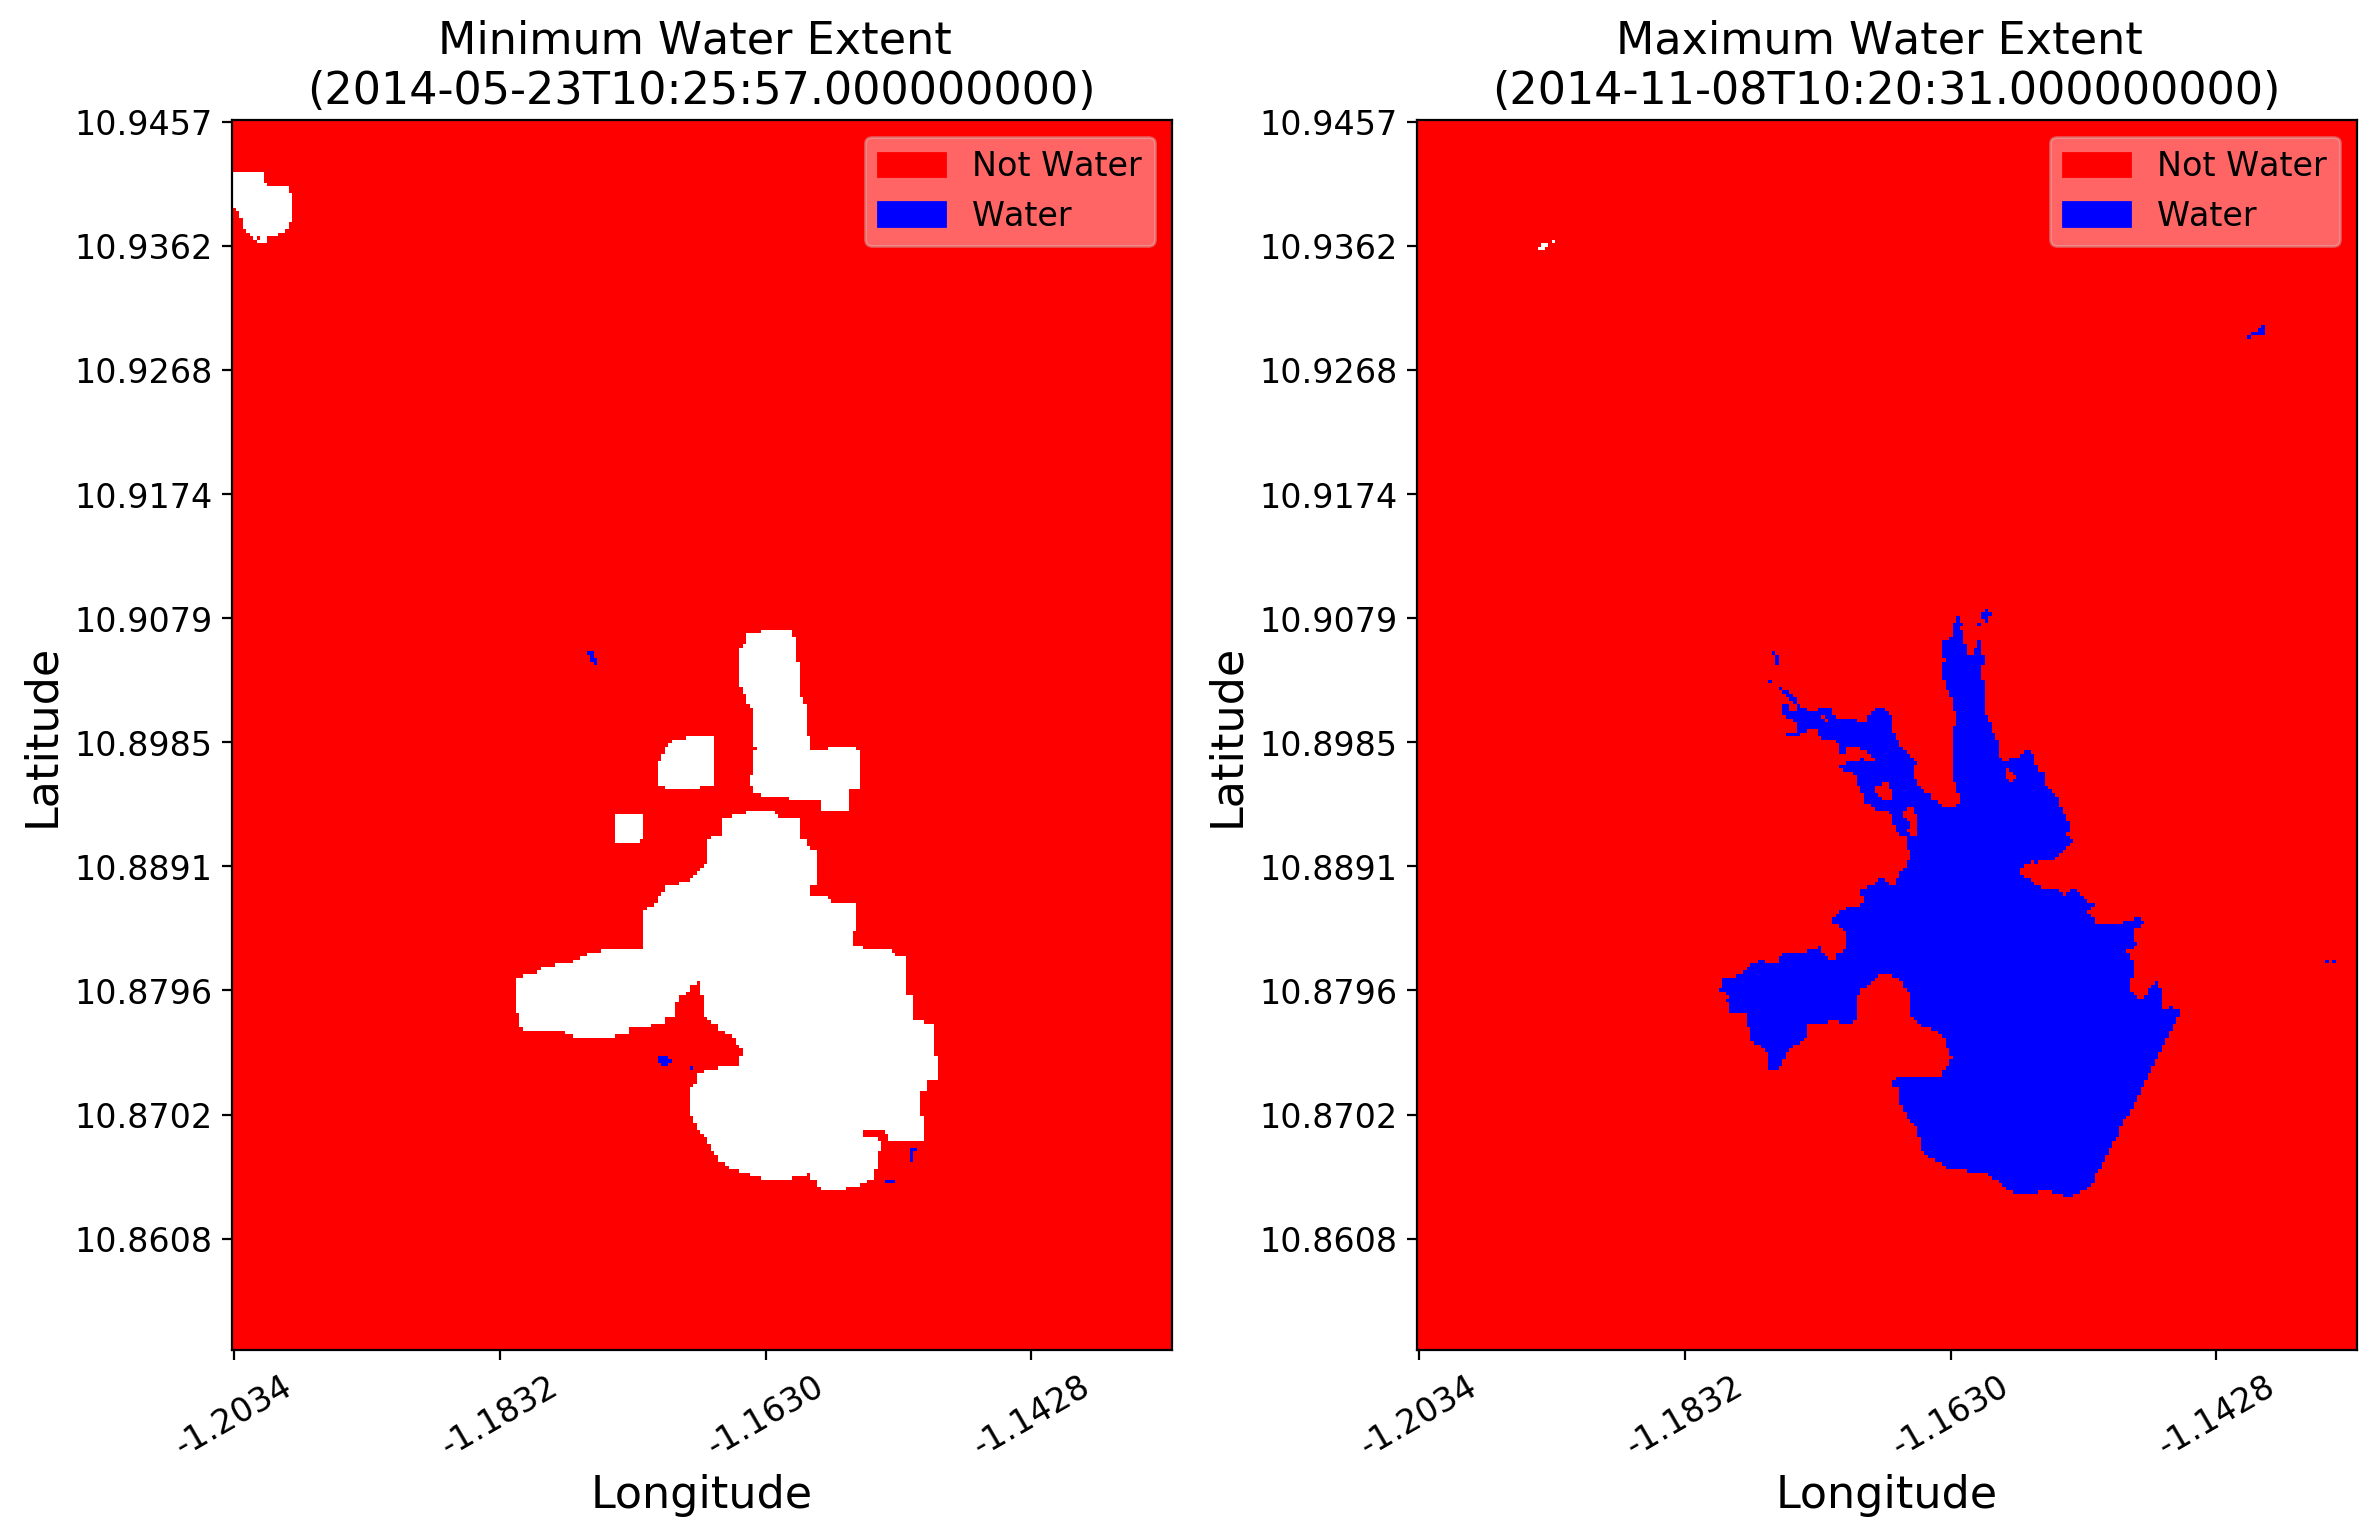

In [19]:
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map, xarray_imshow
from utils.data_cube_utilities.plotter_utils import figure_ratio

# Begin plotting the data
fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(water_arr, fixed_width=fig_width), dpi=std_dpi)

# Create common colormap.
cmap = create_discrete_color_map([0,1], ['red', 'blue'])

imshow_kwargs = dict(vmin=0, vmax=1, cmap=cmap)

legend_labels = {0:'Not Water', 1:'Water'}

# Minimum water extent
ax = plt.subplot(1,2,1)
fig, ax, im, cbar = \
    xarray_imshow(min_water_extent.astype(np.float32), fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs, 
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Minimum Water Extent \n({})".format(min_extent_time), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

# Maximum water extent
ax = plt.subplot(1,2,2)
fig, ax, im, cbar = \
    xarray_imshow(max_water_extent.astype(np.float32), fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs,
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Maximum Water Extent \n({})".format(max_extent_time), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

plt.tight_layout()
plt.show()

### <a id="water_extent_image"></a>**Create Water Extent Image** [&#9652;](#top)

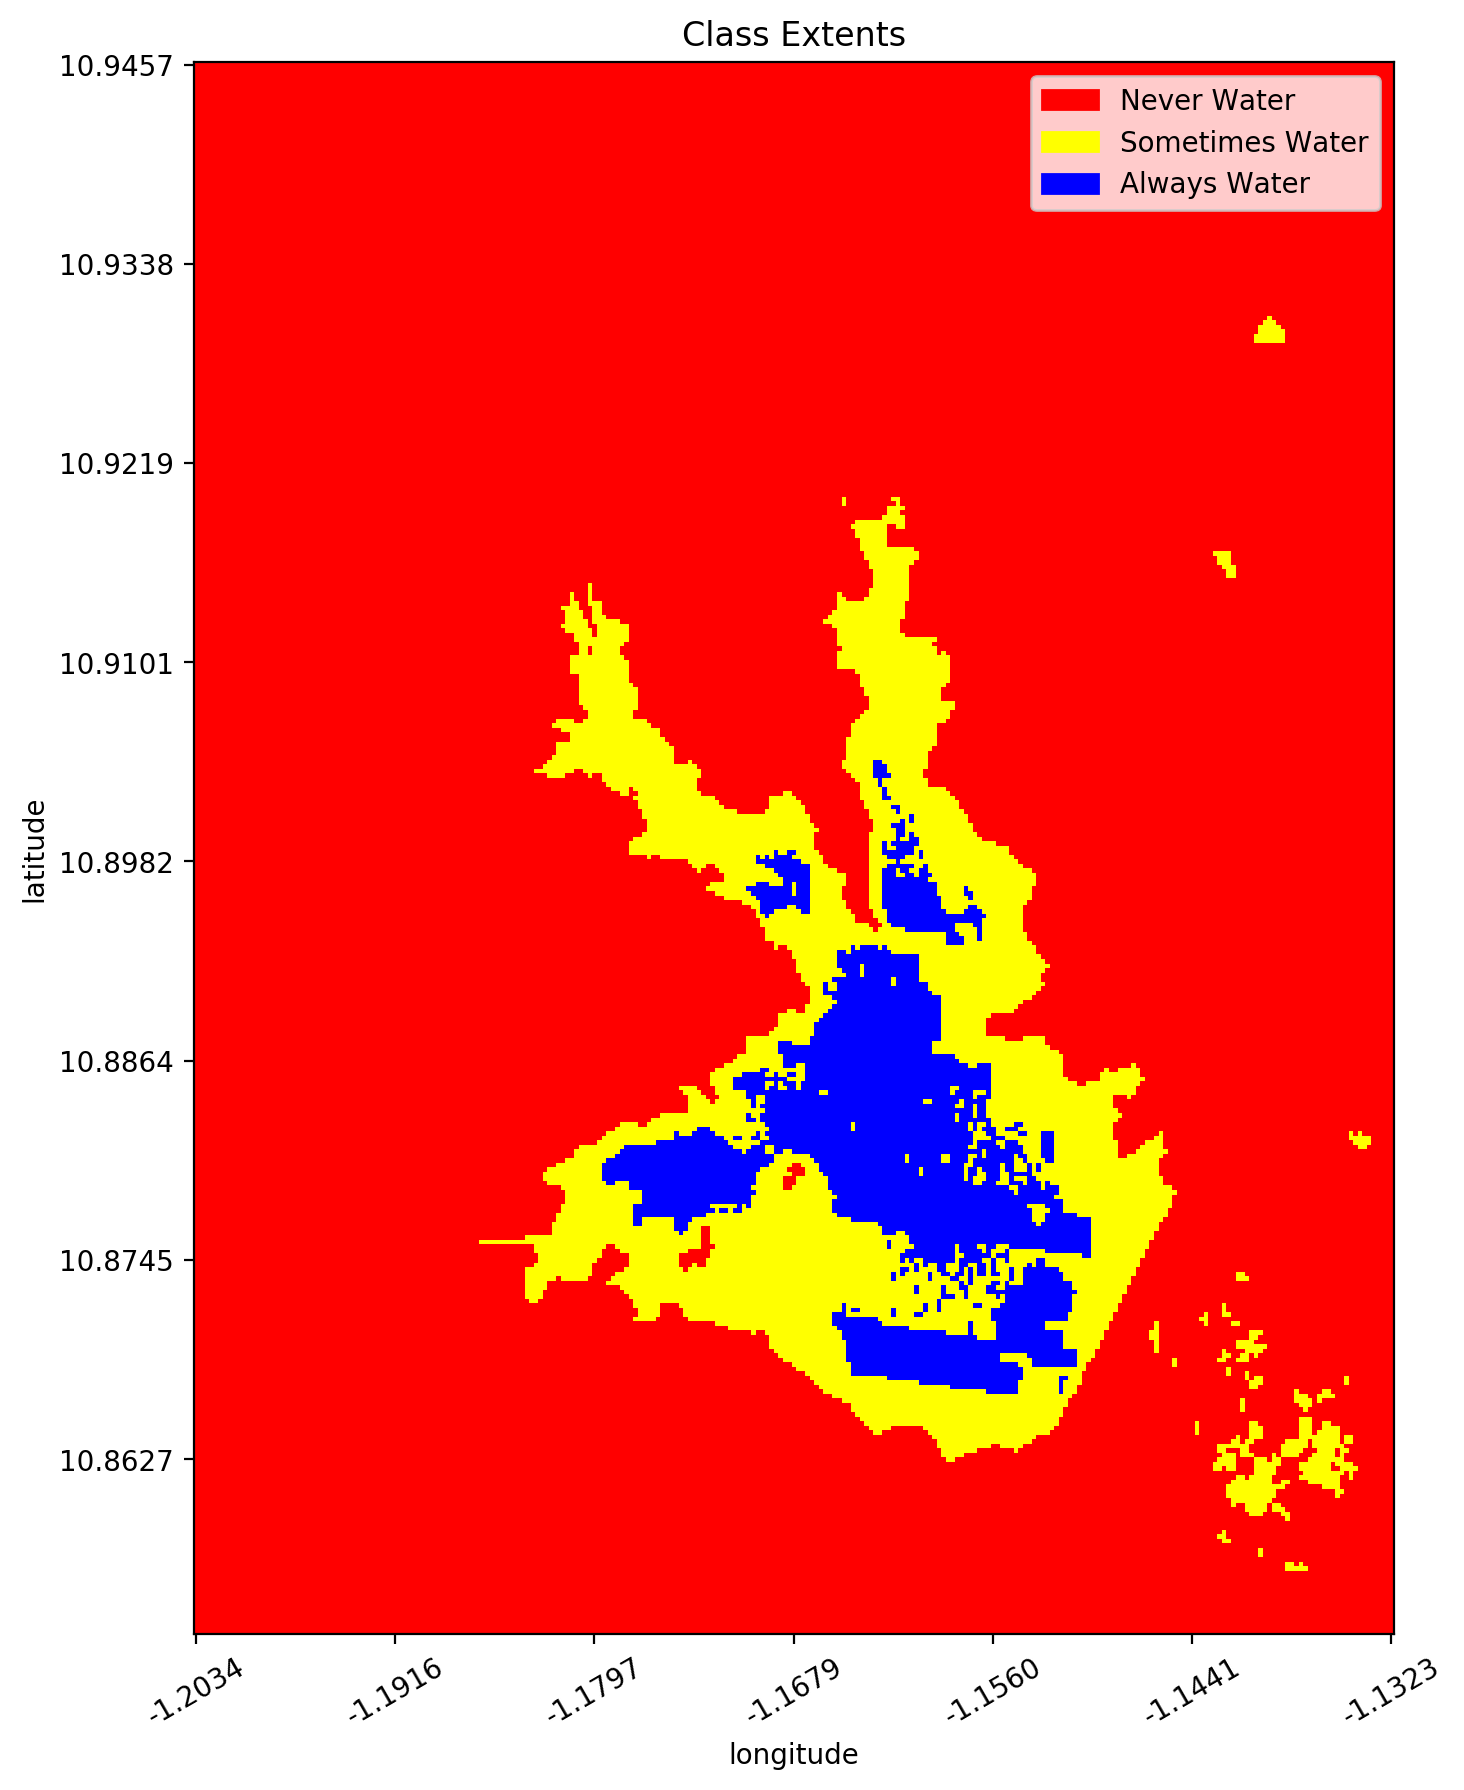

In [20]:
from utils.data_cube_utilities.plotter_utils import binary_class_change_plot

fig_width = 6 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(water_arr, fixed_width=fig_width), dpi=std_dpi)

# Shade 3 regions - never, sometimes, and always water.
(fig,ax), [stats_table] = \
    binary_class_change_plot(
        [water_arr], [clean_mask], colors=['red', 'yellow', 'blue'], 
        class_legend_label='Water', fig=fig)
plt.show()

### <a id="time_series_water"></a>Create a Time Series Plot of the Water [&#9652;](#top)

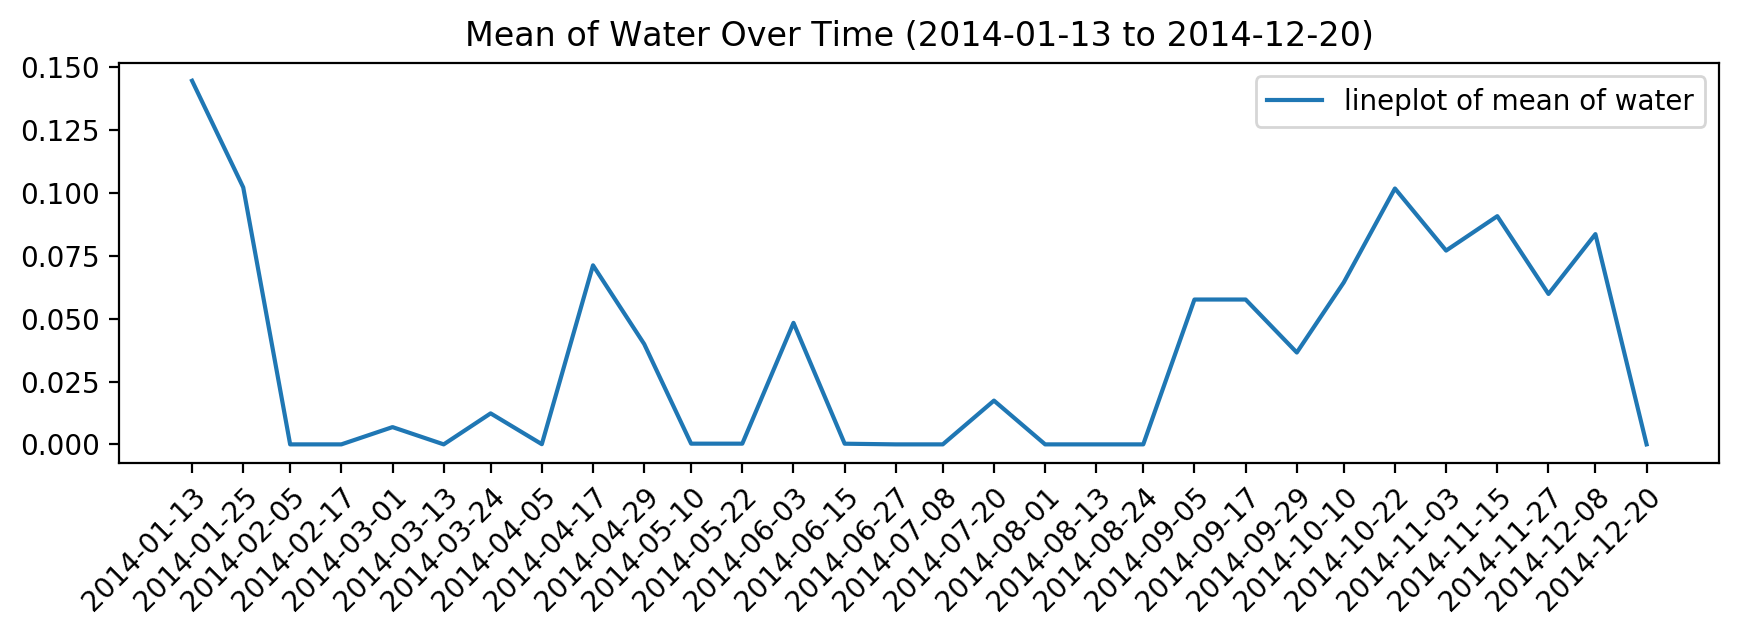

In [21]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot
from utils.data_cube_utilities.aggregate import xr_sel_time_by_bin
from utils.data_cube_utilities.plotter_utils import np_dt64_to_str

water_ds = water_arr.to_dataset('water')

# Show only some of the times to avoid cluttering the figure with tick labels.
plotting_data = xr_sel_time_by_bin(water_ds, num_bins=min(30, len(water_ds.time)))

figsize = (8, 2) # The width and height of the figure, respectively.
fig = plt.figure(figsize=figsize, dpi=std_dpi)

xarray_time_series_plot(plotting_data, fig=fig,
                        plot_descs={'water':  {'mean': [{'line': {}}]}},
                        show_legend=True, title='Mean of Water Over Time')
plt.show()

## <a id="two_period"></a>Compare Two Time Periods - a Baseline and an Analysis [&#9652;](#top)

### <a id="define_extents_baseline_analysis"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates**

In [22]:
# Select a subset of the time available.
date_ranges = {'baseline': [dt.datetime(2002,1,1), dt.datetime(2002,12,31)],
               'analysis': [dt.datetime(2017,1,1), dt.datetime(2017,12,31)]}

**Visualize the selected area**

In [23]:
display_map(lat, lon)

### <a id="retrieve_data_baseline_analysis"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [24]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

datasets = {} # Maps categories to cleaned datasets.
clean_masks = {} # Maps categories to clean masks.
datasets_median_composites = {}
for category, time_extents in list(date_ranges.items()):
    # Use LANDSAT_7 for the baseline because its SLC was broken afterward (2003).
    if category == 'baseline':
        platform, product = platforms[0], products[0]
    else: 
        platform, product = platforms[1], products[1]
    datasets[category], clean_masks[category] = load_for_time_range(platform, product, time_extents)
    datasets_median_composites[category] = \
        create_median_mosaic(datasets[category], clean_masks[category])

### <a id="water_cls_baseline_analysis"></a>Get Water Classifications Using the WOFS Algorithm [&#9652;](#top)

In [25]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings
from utils.data_cube_utilities.raster_filter import lone_object_filter

# Get WOFS classifications.
water_arrs = {}
for category in datasets:
    water_arr = ignore_warnings(wofs_classify, datasets[category]).wofs
    water_arr = water_arr.where((water_arr!=-9999) & clean_masks[category])
    
    # Denoise the classifications.
    if denoise:
        for time in water_arr.time:
            water_arr = water_arr.sel(time=time).values
            water_arr[:] = lone_object_filter(water_arr, **std_denoise_params)
    
    water_arrs[category] = water_arr

### <a id="show_water_extents"></a>**Show Water Extents of the Baseline and Analysis Periods** [&#9652;](#top)

**Show the median composite for each period.**
<br>The results are displayed using a false color RGB where water is dark blue

In [26]:
from utils.data_cube_utilities.plotter_utils import figure_ratio

## Settings ##

# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)
std_dpi = 200 # Standard image dpi.

def std_figsize(fig_width): 
    return figure_ratio(datasets['baseline'].isel(time=0), fixed_width=fig_width)

# This is the name of the band used as the 
# graysale background when showing water extents.
background_band = 'swir1'

## End Settings ##

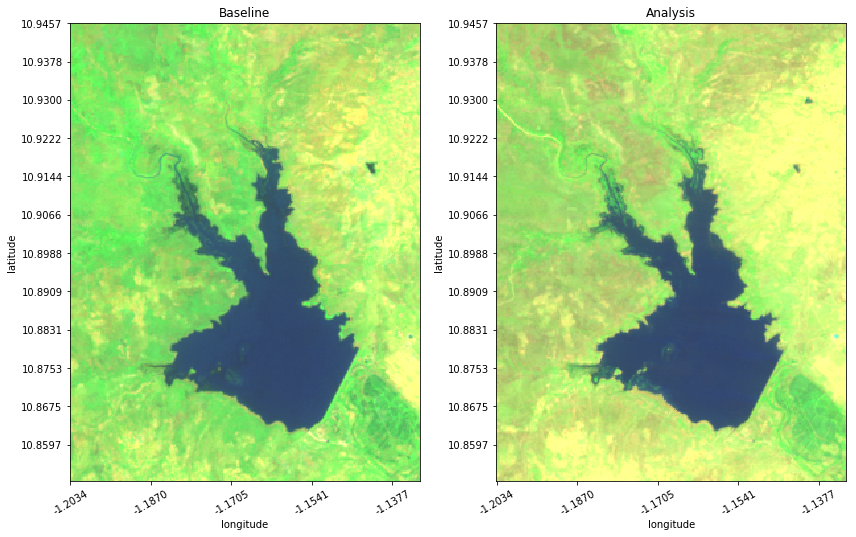

In [27]:
from utils.data_cube_utilities.dc_rgb import rgb

fig_width = 12 # Use this to change the size of this figure.
fig, ax = plt.subplots(1, 2, figsize=std_figsize(fig_width))

for i, category in enumerate(water_arrs):
    rgb(datasets_median_composites[category], fig=fig, ax=ax[i], 
        bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=3000)
    ax[i].set_title(category.capitalize())
plt.tight_layout()
plt.show()

**Show which pixels are sometime water or always water for each period, with a gray-scale background.**
<br>Warning: These results can be impacted by cloud contamination. The identification of clouds in Landsat <br>scenes is not perfect, so errors in cloud identification can impact time series results

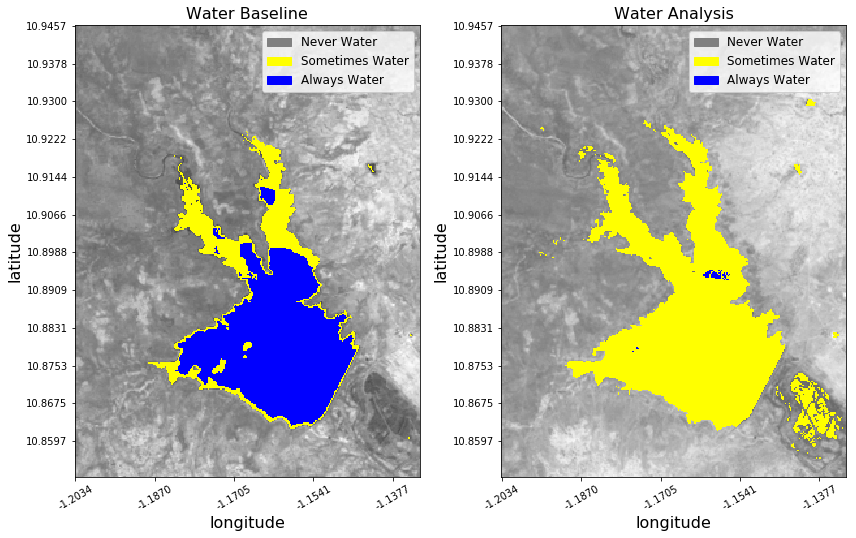

In [28]:
from utils.data_cube_utilities.plotter_utils import binary_class_change_plot

fig_width = 12 # Use this to change the size of this figure.
fig, ax = plt.subplots(1, 2, figsize=std_figsize(fig_width))

# Collect stats tables for each period so we can later create a change matrix.
stats_tables = {}

for i, category in enumerate(water_arrs):
    # Show water in blue over a grey-scale background.
    rgb(datasets_median_composites[category], bands=[background_band]*3, 
        ax=ax[i], use_data_min=True, use_data_max=True)
    water_composite = water_arrs[category].where(clean_masks[category], 0).mean('time')
    [fig, ax[i]], [stats_tables[category]] = \
    binary_class_change_plot(
        [water_arrs[category]],
        [clean_masks[category]],
        colors=['gray', 'yellow', 'blue'], 
        neg_trans=True,
        class_legend_label='Water', fig=fig, ax=ax[i], 
        title_kwargs=dict(label='Water ' + category.capitalize(), fontdict=title_fontdict),
        x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict, 
        legend_kwargs=legend_kwargs, 
        denoise=denoise, denoise_params=std_denoise_params)
plt.tight_layout()
plt.show()

### <a id="show_analyze_diff"></a>**Show and Analyze the Differences Between the Two Time Periods** [&#9652;](#top)

Compare the water extents of the cloud-filtered mosaics of the baseline and analysis time periods

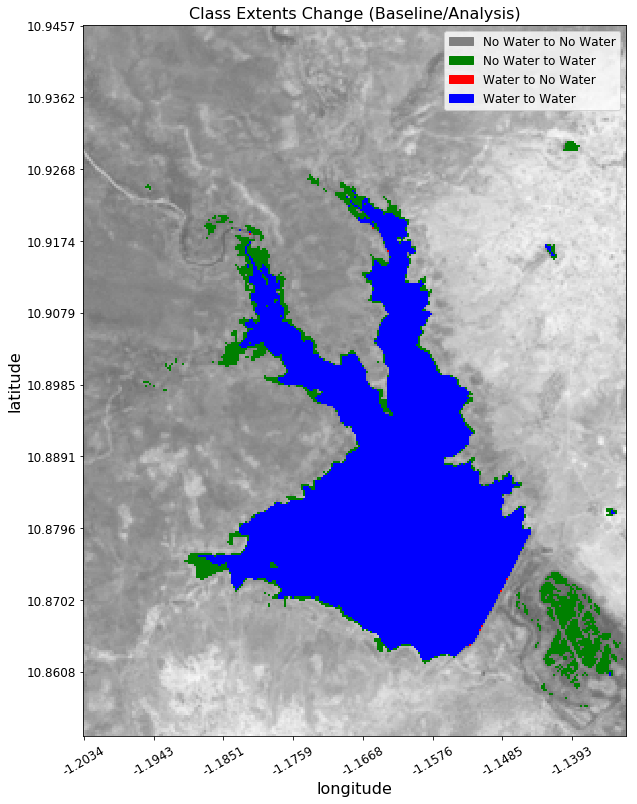

In [29]:
fig_width = 10 # Use this to change the size of this figure.
fig, ax = plt.subplots(figsize=std_figsize(fig_width))

# Show water change over a grey-scale background.
rgb(datasets_median_composites[category], bands=[background_band]*3, 
    ax=ax, use_data_min=True, use_data_max=True)
# Show regions based on changes between having zero or more than zero times 
# in which they are classified as water between the two time periods.
[fig, ax], [stats_table, change_matrix] = \
    binary_class_change_plot(
        [water_arrs['baseline'], water_arrs['analysis']],
        [clean_masks['baseline'], clean_masks['analysis']],
        colors=['gray', 'green', 'red', 'blue'], 
        neg_trans=True,
        class_legend_label='Water', fig=fig, ax=ax, title_kwargs=dict(fontdict=title_fontdict),
        x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict, 
        legend_kwargs=legend_kwargs, 
        denoise=denoise, denoise_params=std_denoise_params)
ax.tick_params(**tick_label_fmt_dict)
plt.show()

**Change Statistics**

In [30]:
# Add area to the stats table.
# 1. Get resolution. In this case, we know the x and y coordinates are longitude and latitude
#    and that the products all have the same resolution.
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == products[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
meters_per_px = 111000 * deg_per_px
# 2. Calculate the total area
length_in_meters = meters_per_px * np.array([len(water_arrs['baseline'].latitude),
                                             len(water_arrs['baseline'].longitude)])
total_area_in_meters = np.prod(length_in_meters)
# 3. Compute the area for each row of the stats table and display the table.
stats_table.loc[:, 'Area (m^2)'] = stats_table.loc[:,'Percent'] * total_area_in_meters
stats_table

,Number,Percent,Area (m^2)
No Water to No Water,75028,0.815921,6.713816e+07
No Water to Water,2476,0.026926,2.215627e+06
Water to No Water,8,0.000087,7.158731e+03
Water to Water,14443,0.157066,1.292419e+07
Net Change,2484,0.027013,2.222786e+06
Unknown,0,0.000000,0.000000e+00


**Change Matrix**

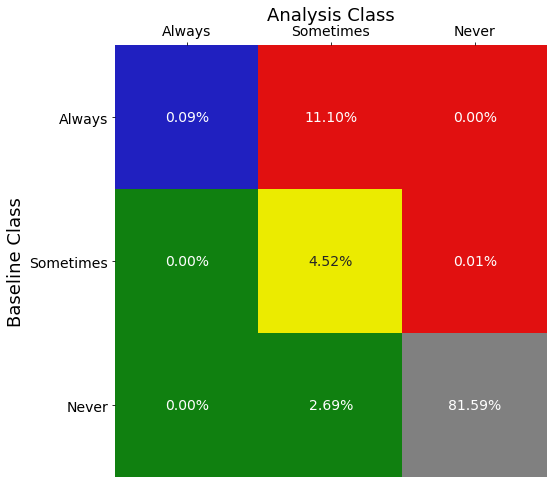

In [31]:
from utils.data_cube_utilities.dc_utilities import reverse_array_dict
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map
from utils.data_cube_utilities.plotter_utils import print_matrix

# Create a colormap for coloring the cells in the change matrix.
# The colors are, in order, gray, red, green, yellow, and blue. Many are manually specified
# as rgb lists because their matplotlib named colors are fairly bright and saturated.
change_matrix_cmap = \
    create_discrete_color_map([0,4], colors=['gray', [225,16,16], [16,128,16], [235,235,0], [32,32,192]])

# This is a matrix specifying each class transition based on the color it should recieve.
# Original classes are indexed by row and final classes are indexed by column.
cng_vals = [0, 1, 2, 3, 4]
cng_mat = np.array([
    # Always Sometimes Never
    [     4,      1,      1], # Always
    [     2,      3,      1], # Sometimes 
    [     2,      2,      0], # Never   
])

# Create mappings of transitions to values for coloring based on a colormap.
cls_trans_for_value = {cng_val:[] for cng_val in cng_vals}
for i, orig_class in enumerate(change_matrix.baseline.values):
    for j, final_class in enumerate(change_matrix.analysis.values):
        cng_val = cng_mat[i,j]
        cls_trans_for_value[cng_val].append((orig_class, final_class))
value_for_cls_trans = reverse_array_dict(cls_trans_for_value)

# Create the cell value matrix (used to color cells).
cell_value_mtx = np.empty_like(change_matrix.Percent.values)
for i, cls_label1 in enumerate(change_matrix.baseline.values):
    for j, cls_label2 in enumerate(change_matrix.analysis.values):
        cell_value_mtx[i,j] = value_for_cls_trans[(cls_label1, cls_label2)]

cell_label_mtx = np.full_like(cell_value_mtx, '', dtype=object)
for i, baseline_category in enumerate(change_matrix['baseline']):
    for j, analysis_category in enumerate(change_matrix['analysis']):
        cell_label_mtx[i,j] = "{0:.2%}".format(change_matrix.Percent.values[i,j])

row_labels = [label.capitalize() for label in change_matrix.baseline.values]
col_labels = [label.capitalize() for label in change_matrix.analysis.values]

fig = plt.figure(figsize=(6,6))
fig, ax = print_matrix(cell_value_mtx, cell_val_fmt='s',
                       cell_label_mtx=cell_label_mtx, cmap=change_matrix_cmap,
                       row_labels=row_labels, col_labels=col_labels, 
                       x_axis_ticks_position='top', x_axis_tick_kwargs={},
                       annot_kwargs=dict(size=14), fig=fig)
ax.yaxis.set_label_position('left')
plt.ylabel('Baseline Class', fontsize=18)
ax.xaxis.set_label_position('top')
plt.xlabel('Analysis Class', fontsize=18)
plt.show()

**Calculate the area of each of the 9 transition classes in the change matrix.**

In [32]:
# 1. Get resolution. In this case, we know the x and y coordinates are longitude and latitude
#    and that the products all have the same resolution.
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == products[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
meters_per_px = 111000 * deg_per_px

change_matrix['Area (m^2)'] = change_matrix.Number * np.prod(meters_per_px)
cng_mtx_as_table = change_matrix.to_dataframe().reset_index()
baseline_analysis_cls_strs = cng_mtx_as_table[['baseline', 'analysis']].values
cng_mtx_as_table.drop(columns=['analysis', 'baseline'], inplace=True)
cng_mtx_as_table.index = ["{} to {}".format(base_cls, analysis_cls) for base_cls, analysis_cls 
                            in baseline_analysis_cls_strs]
cng_mtx_as_table.style.format({'percent': "{:.2%}"})

,Number,Percent,Area (m^2)
always to always,82,0.000891741,73377
sometimes to always,0,0,0
never to always,0,0,0
always to sometimes,10207,0.111,9.13365e+06
sometimes to sometimes,4154,0.0451743,3.71717e+06
never to sometimes,2476,0.0269262,2.21563e+06
always to never,0,0,0
sometimes to never,8,8.69991e-05,7158.73
never to never,75028,0.815921,6.71382e+07


### <a id="classify_by_degree_change"></a>**Classifiy the Area by Degree of Change** [&#9652;](#top)

In [33]:
# Transitions from never water to some/always water (and vice versa) are considered changes.
frac_change_cls = stats_table.loc[['No Water to Water', 'Water to No Water'], ['Percent']].sum()[0]

region_class = None
frac_change_cls = abs(frac_change_cls)
if frac_change_cls <= 0.1:
    region_class = "Unmodified Natural (class A)"
if 0.1 < frac_change_cls <= 0.2:
    region_class = "Largely Natural (class B)"
if 0.2 < frac_change_cls <= 0.4:
    region_class = "Moderately Modified (class C)"
if 0.4 < frac_change_cls <= 0.6:
    region_class = "Largely Modified (class D)"
if 0.6 < frac_change_cls:
    region_class = "Seriously Modified (class E)"
print("The percent of pixels that have changed class relative to the baseline time period " \
      "is {0:.3%}, so this region can be classfied as {1}".format(frac_change_cls, region_class))

The percent of pixels that have changed class relative to the baseline time period is 2.701%, so this region can be classfied as Unmodified Natural (class A)
